In [1]:
import pandas as pd
import numpy as np

# Define column names
columns = ['unit_number', 'time_in_cycles',
           'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

# Load data
df_train = pd.read_csv('~/OneDrive/Bureau/FD001/train_FD001.txt', sep='\s+', header=None, names=columns)
df_test = pd.read_csv('~/OneDrive/Bureau/FD001/test_FD001.txt', sep='\s+', header=None, names=columns)
df_rul = pd.read_csv('~/OneDrive/Bureau/FD001/RUL_FD001.txt', header=None, names=['RUL'])


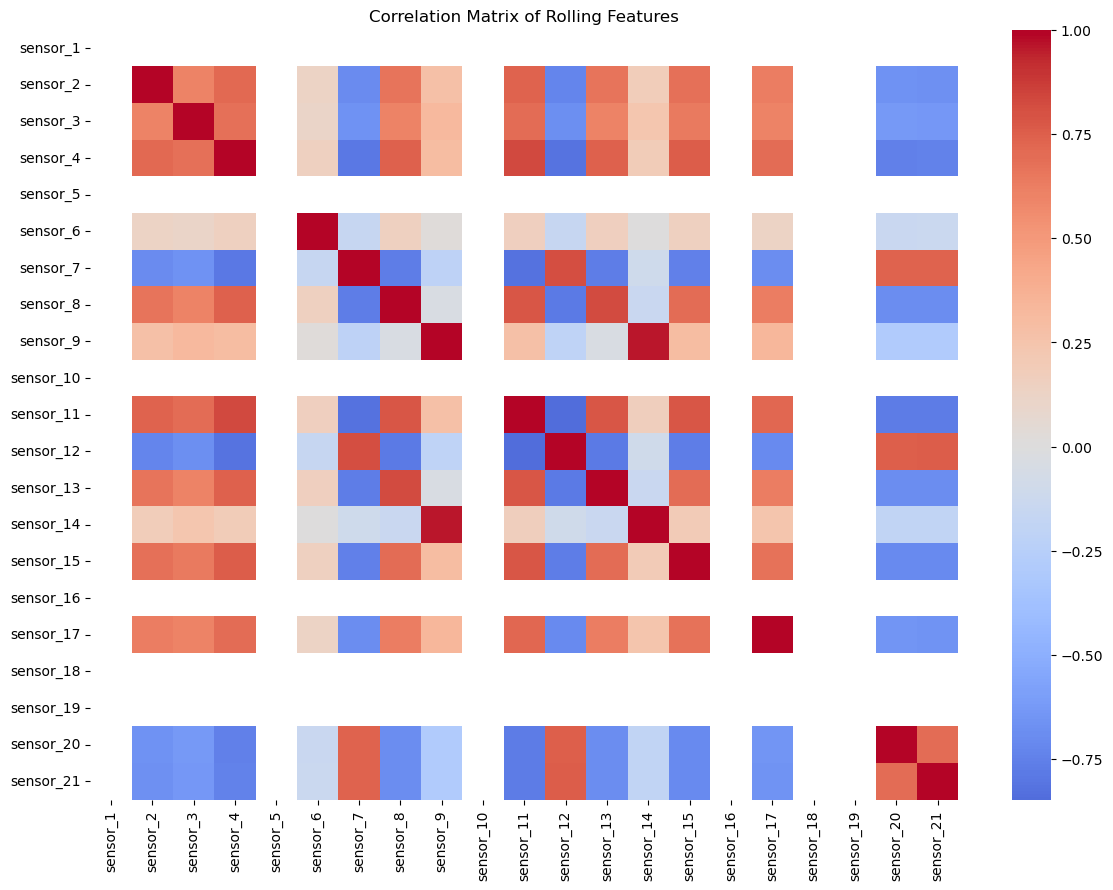

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Ensure you drop the correct columns (axis=1, and remove leading space)
columns_to_drop = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3']
df_cor = df_train.drop(columns=columns_to_drop, axis=1)

# Compute correlation matrix
corr_matrix = df_cor.corr()

# Plot a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Rolling Features")
plt.show()


In [3]:
# Drop highly correlated features (threshold = 0.95)
def get_redundant_pairs(df_corr):
    pairs_to_drop = set()
    cols = df_corr.columns
    for i in range(0, df_corr.shape[1]):
        for j in range(i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, threshold=0.95):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr > threshold]

# Display highly correlated pairs
high_corr = get_top_abs_correlations(df_train)
print(high_corr)


sensor_9  sensor_14    0.963157
dtype: float64


In [4]:
# Drop features with >0.95 correlation
corr_matrix = df_train[[col for col in df_train.columns if 'roll' in col]].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_train_reduced = df_train.drop(columns=high_corr_cols)
X_test_reduced = df_test.drop(columns=high_corr_cols)

# Filter to keep only roll features
feature_cols = [col for col in X_train_reduced.columns if 'roll' in col]


In [5]:
# Compute RUL for each row in training set
max_cycles = df_train.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']
df_train = df_train.merge(max_cycles, on='unit_number')
df_train['RUL'] = df_train['max_cycle'] - df_train['time_in_cycles']
df_train.drop('max_cycle', axis=1, inplace=True)


In [6]:
# RUL at final cycle for each test engine
test_max_cycles = df_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max_cycles.columns = ['unit_number', 'max_cycle']
test_max_cycles['RUL_at_end'] = df_rul['RUL']
df_test = df_test.merge(test_max_cycles, on='unit_number')
df_test['RUL'] = df_test['RUL_at_end'] + (df_test['max_cycle'] - df_test['time_in_cycles'])
df_test.drop(columns=['max_cycle', 'RUL_at_end'], inplace=True)


In [7]:
def label_rul(rul):
    if rul > 30:
        return 'healthy'
    elif rul > 10:
        return 'warning'
    else:
        return 'critical'

df_train['health_state'] = df_train['RUL'].apply(label_rul)
df_test['health_state'] = df_test['RUL'].apply(label_rul)


In [8]:
rolling_window = 5
selected_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

for df in [df_train, df_test]:
    for sensor in selected_sensors:
        df[f'{sensor}_roll_mean'] = df.groupby('unit_number')[sensor].transform(
            lambda x: x.shift().rolling(window=rolling_window, min_periods=1).mean()
        )
        df[f'{sensor}_roll_std'] = df.groupby('unit_number')[sensor].transform(
            lambda x: x.shift().rolling(window=rolling_window, min_periods=1).std()
        )



In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Features and labels
feature_cols = [col for col in df_train.columns if 'roll' in col]
X_train = df_train[feature_cols].fillna(0)
y_train = df_train['health_state']

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

X_test = df_test[feature_cols].fillna(0)
y_test = label_encoder.transform(df_test['health_state'])


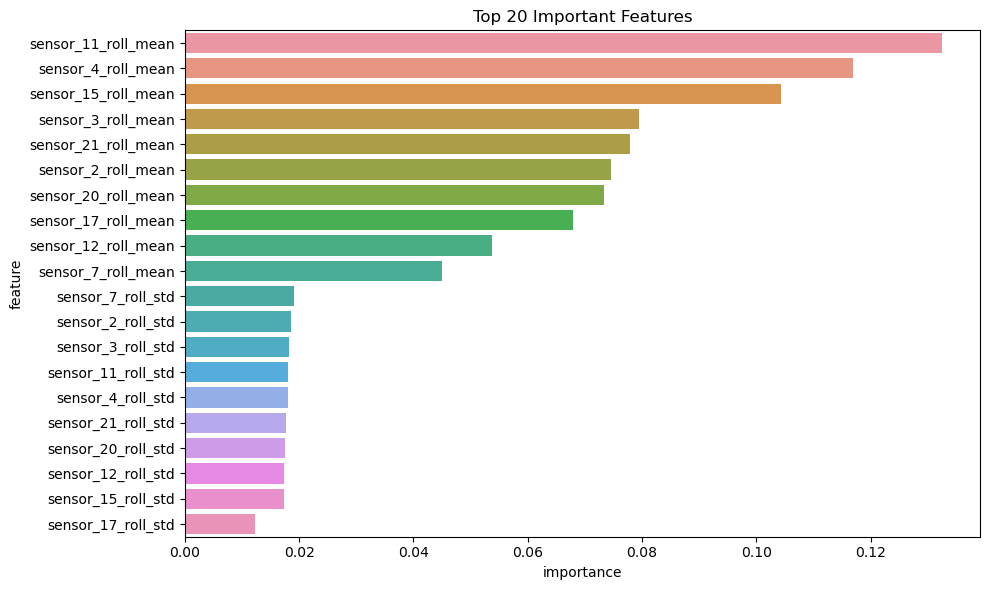

In [10]:
# Fit model if not already done
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_encoded)

# Create importance DataFrame
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

In [11]:
important_features = feature_importance[feature_importance['importance'] > 0.02]['feature'].tolist()
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

In [12]:
# Train model
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
clf.fit(X_train_reduced, y_train_encoded)

# Predict
y_pred = clf.predict(X_test_reduced)

# Report
report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
conf_matrix = confusion_matrix(y_test, y_pred)

# Display
print("Confusion Matrix:\n", conf_matrix)
report_df


Confusion Matrix:
 [[    7     0    10]
 [    0 12703    61]
 [    5   159   151]]


,precision,recall,f1-score,support
critical,0.583333,0.411765,0.482759,17.000000
healthy,0.987638,0.995221,0.991415,12764.000000
warning,0.680180,0.479365,0.562384,315.000000
accuracy,0.982056,0.982056,0.982056,0.982056
macro avg,0.750384,0.628784,0.678852,13096.000000
weighted avg,0.979718,0.982056,0.980435,13096.000000


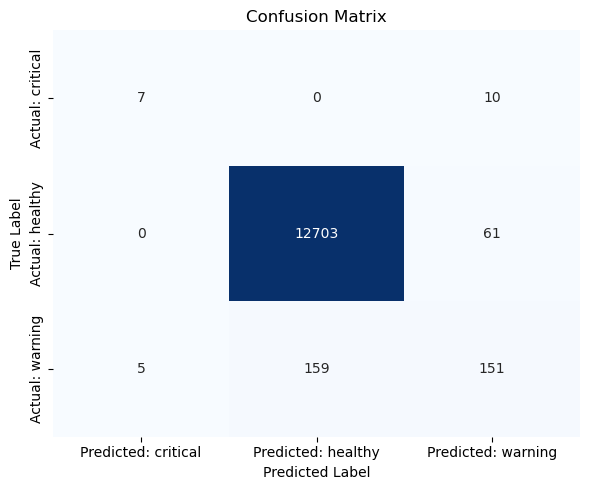

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Reuse predictions and true labels
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

# Create a DataFrame for easy display
cm_df = pd.DataFrame(cm, index=[f"Actual: {label}" for label in labels],
                        columns=[f"Predicted: {label}" for label in labels])

# Plot it nicely
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
